## Predictive Modeling (GMS) - By Puzzle Day Modeling

This is the by-puzzle-day version of 04_Modeling, which found best model across all 15x15 puzzles (Mon-Sat) together. A Linear Model was found to work best for all 15x15 puzzles (overall 'Best Model'), so that is also used here. Best hyperparameters are found for individual puzzle day models per day separately. 

An 80/20 Train/Test split is used to maximize data while still having a large enough test set to ensure we aren't overfitting to a large degree. 

Note also that puzzles from the first solve period (2018) have been removed due to the volatility of times in that solve period. Features (GMS 'past performance' class) with accrual, however, still accrued from that period prior to its removal. 

### Summary of Previous Stage (see Notebook 3; Preprocessing_Training_CompletionRangeFiltered)

#### 2 Linear Regression "Benchmark" models were generated to predict GMS solve times on 15x15 (Mon-Sat) puzzles:
* 1) A "dummy" model, which simply uses mean of training data split to predict target feature -GMS's raw solve time (in min)
    * Root Mean Squared Error (RMSE) Training Set: 8.12;  Test Set: 8.49 
* 3) A univariate linear model using GMS's puzzle-day specific mean solve time across the entire sample as the sole predictive feature (ie, if predicting a Mon GMS solve time, GMS Mon mean across the entire sample is used to predict)
    * Root Mean Squared Error (RMSE) Training Set: 4.37(.21);  Test Set: 4.45
 
75%/25% Train/Test split was used for each of these Benchmark models

### High-Level Overview of Overall 15x15 Puzzles Modeling

Four regression models were evaluated across the entire sample of 15x15 puzzles solved by the GMS. First was simply a Linear Regression Model. The subsequent three models were decision tree models: Random Forest, Gradient Boosting Regressor and HistGradient Boosting Regressor. The latter is an ensemble machine learning algorithm that is very fast (relative to standard gradient boosting models), and performs well on heterogenous data sets. Boosting, generally, refers to a class of ensemble learning algorithms that add tree models to an ensemble sequentially. 

Note: After multiple modeling iterations, both the short-term (past 10 puzzles) and intermediate-term (past 25 puzzles) GMS past-performance features were removed. This left only long-term (past 40 puzzles). These actions were found to yield slightly superior predictions compared to including all 3 or 2 of the 3. 

### Imports

In [18]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [19]:
# Load data
# 2018 already filtered out
df = pd.read_csv('../data/df_for_modeling.csv')
df.head()

,P_Date,P_Date_str,GMS_Completed,DOW,DOW_num,GMST(m),GMS_pds_l10_dw,GMS_pds_l25_dw,GMS_pds_l40_dw,GMS_pds_l10_stdev,...,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay,overall_day_mean_GMST(m)
0,2024-02-10,2024-02-10,1,Saturday,7.0,16.533333,22.473939,22.678667,23.289248,4.981753,...,0,1,0,0,0,0,0,0,6.0,26.505868
1,2024-02-09,2024-02-09,1,Friday,6.0,18.000000,17.519091,17.517333,18.048516,3.542548,...,0,0,0,0,0,0,0,0,6.0,21.438951
2,2024-02-08,2024-02-08,1,Thursday,5.0,15.600000,14.662121,17.007333,19.198943,2.654801,...,0,0,0,0,0,0,0,0,6.0,20.690762
3,2024-02-07,2024-02-07,1,Wednesday,4.0,11.850000,11.543636,12.573333,11.583069,2.224982,...,0,0,0,0,0,0,0,0,2.0,13.254744
4,2024-02-06,2024-02-06,1,Tuesday,3.0,8.716667,7.610606,7.881333,8.097398,1.159902,...,0,0,0,0,0,0,0,0,7.0,9.716916


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   P_Date                                 1867 non-null   object 
 1   P_Date_str                             1867 non-null   object 
 2   GMS_Completed                          1867 non-null   int64  
 3   DOW                                    1867 non-null   object 
 4   DOW_num                                1867 non-null   float64
 5   GMST(m)                                1867 non-null   float64
 6   GMS_pds_l10_dw                         1867 non-null   float64
 7   GMS_pds_l25_dw                         1867 non-null   float64
 8   GMS_pds_l40_dw                         1867 non-null   float64
 9   GMS_pds_l10_stdev                      1867 non-null   float64
 10  GMS_pds_l25_stdev                      1867 non-null   float64
 11  GMS_

In [375]:
# Drop some columns that we don't want/need for modeling
df_filter = df.copy()
df_filter.drop(['P_Date','P_Date_str', 'GMS_Completed','DOW', 'GMST_Diff%_from_GMS_pds_l40_dw','GMS_per_constr_past_diff_from_RPB_ct','Constructors','overall_day_mean_GMST(m)','Uniclue','Duplicate_Answers','Unchecked_Sq','Quantum'],inplace=True,axis=1)

In [376]:
# Also now drop short and intermediate-term GMS past performance features
#Imperative for final model performance
df_filter.drop(['GMS_pds_l10_dw','GMS_pds_l25_dw','GMS_pds_l10_stdev','GMS_pds_l25_stdev'],inplace=True,axis=1) #linear RMSE: (3.953721267825486, 0.231741035464759) 
#df_filter.drop(['GMS_pds_l10_dw','GMS_pds_l10_stdev'],inplace=True,axis=1) #linear RMSE: (3.9576275009691413, 0.22676168953792353)
#df_filter.drop(['GMS_pds_l10_dw','GMS_pds_l50_dw','GMS_pds_l10_stdev','GMS_pds_l50_stdev'],inplace=True,axis=1) #linear RMSE: (3.9670459176013635, 0.21705983140955096)
#df_filter.drop(['GMS_pds_l25_dw','GMS_pds_l50_dw','GMS_pds_l25_stdev','GMS_pds_l50_stdev'],inplace=True,axis=1) #linear RMSE: (3.9840272126935297, 0.237305851677329)
#df_filter.drop(['GMS_pds_l10_dw','GMS_pds_l25_dw','GMS_pds_l50_dw','GMS_pds_l10_stdev','GMS_pds_l25_stdev','GMS_pds_l50_stdev'],inplace=True,axis=1) #linear RMSE: (4.043534832823217, 0.23857038246642934)

In [377]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   DOW_num                                1867 non-null   float64
 1   GMST(m)                                1867 non-null   float64
 2   GMS_pds_l40_dw                         1867 non-null   float64
 3   GMS_pds_l40_stdev                      1867 non-null   float64
 4   GMS_per_constr_avg_past_diff_from_RPB  1292 non-null   float64
 5   GMS_pds_prior_solves_ct                1867 non-null   float64
 6   GMS_npds_prior_solves_ct               1867 non-null   float64
 7   Words                                  1867 non-null   int64  
 8   Blocks                                 1867 non-null   int64  
 9   Unused_Letters                         1867 non-null   int64  
 10  Stacks                                 1867 non-null   int64  
 11  Uniq

In [378]:
#Move target feature to the front
col = df_filter.pop('GMST(m)')
df_filter.insert(0, col.name, col)

In [379]:
# Filter to a specific puzzle day
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 1)]) # Sun
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 2)]) # Mon
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 3)]) # Tue
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 4)]) # Wed
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 5)]) # Thu
df_filter = (df_filter.loc[(df_filter['DOW_num'] == 6)]) # Fri
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 7)]) # Sat

In [380]:
df_filter.drop(['DOW_num'],inplace=True,axis=1)

In [381]:
#Deep copy of this df_filter that is now pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given puzzle being predicted on. No data leakage!
df_model1 = df_filter.copy()

In [382]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 1 to 1863
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   GMST(m)                                267 non-null    float64
 1   GMS_pds_l40_dw                         267 non-null    float64
 2   GMS_pds_l40_stdev                      267 non-null    float64
 3   GMS_per_constr_avg_past_diff_from_RPB  199 non-null    float64
 4   GMS_pds_prior_solves_ct                267 non-null    float64
 5   GMS_npds_prior_solves_ct               267 non-null    float64
 6   Words                                  267 non-null    int64  
 7   Blocks                                 267 non-null    int64  
 8   Unused_Letters                         267 non-null    int64  
 9   Stacks                                 267 non-null    int64  
 10  Unique_Answers                         267 non-null    int64  
 11  Rebus

In [210]:
df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [383]:
len(df_model1) * .80, len(df_model1) * .20

(213.60000000000002, 53.400000000000006)

In [384]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='GMST(m)'), 
                                                    df_model1['GMST(m)'], test_size=0.20, 
                                                    random_state=47)

In [385]:
y_train.shape, y_test.shape

((213,), (54,))

In [386]:
y_train

806     23.250000
183     16.450000
1226    18.783333
295     16.466667
330     23.883333
          ...    
162     17.533333
1254    21.700000
505     20.616667
1849    35.650000
946     16.150000
Name: GMST(m), Length: 213, dtype: float64

In [387]:
X_train.shape, X_test.shape

((213, 30), (54, 30))

In [388]:
#Target feature (GMST(m)) training set mean
train_mean = y_train.mean()
train_mean

21.601877934272316

## Linear Model

In [355]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [356]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [357]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean','median'],
    'selectkbest__k': k
}

In [358]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [359]:
#Conduct grid search. 
lr_grid_cv.fit(X_train, y_train)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000020582D5C820>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [360]:
#Best params from grid search
lr_grid_cv.best_params_

{'selectkbest__k': 20,
 'simpleimputer__strategy': 'median',
 'standardscaler': StandardScaler()}

### K Best Features Visualization

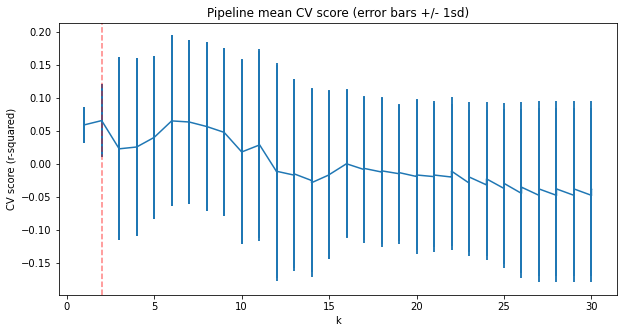

In [297]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Best Linear Model Performance Metrics

#### R-squared (COD)

In [298]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


array([-0.00350323,  0.15727624,  0.02456423,  0.0702712 ,  0.08124091])

In [299]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.06596986903501567, 0.055008177843651994)

#### Mean Absolute Error (MAE)

In [300]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [301]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.943274495591216, 0.8234070834588456)

In [302]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.907580536455778

#### Mean Squared Error (MSE)

In [303]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [304]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(40.47634474268124, 13.566141586023482)

In [305]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

34.396189970523025

#### Root Mean Square Error (RMSE)

In [306]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [307]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(6.276081936647444, 1.0426601877740016)

In [308]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.864826508135004

### Best Linear Model Feature Importance

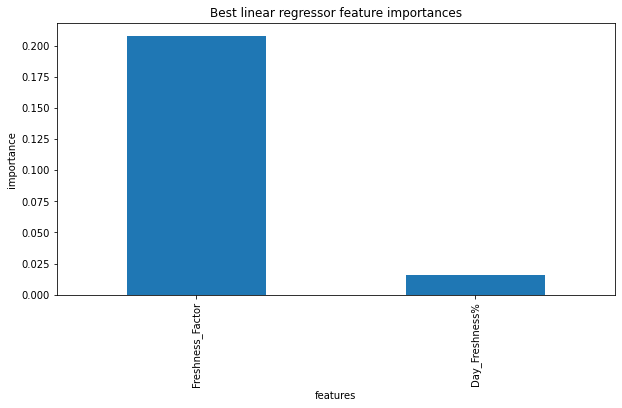

In [309]:
#Plot a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

In [310]:
# Export out features and feature importances for full documentation csv
X_train.columns
lr_feat_imps.to_csv('../data/linear_feat_imps_Sat.csv', index=True)

In [311]:
# save the model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'IS1_full_best_model_linear_Sat.pkl', modelpath)

Writing file.  "../models\IS1_full_best_model_linear_Sat.pkl"


### Data Quality Assessment

In [312]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(lr_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value e

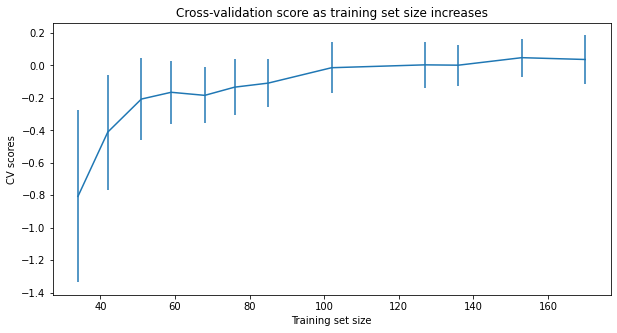

In [313]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

models other than Best Model for all 15x15 are below (not used for by-day assessment)

## Random Forest Regression Model

### Random Forest Model: Hyperparameter Grid Search

In [63]:
#Define pipeline
RF_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [64]:
#Dict of available parameters for RF pipe
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'randomforestregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomf

In [65]:
#Define search grid parameters

#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
n_est = [300]

grid_params = {
        'randomforestregressor__n_estimators': n_est, 
        'randomforestregressor__max_features': [9],
        'randomforestregressor__max_depth': [10],
        'randomforestregressor__min_samples_split': [2],
        'randomforestregressor__min_samples_leaf': [10],
        'standardscaler': [None],
        'simpleimputer__strategy': ['median']}
grid_params

{'randomforestregressor__n_estimators': [275, 300, 325],
 'randomforestregressor__max_features': [9],
 'randomforestregressor__max_depth': [9, 10, 11],
 'randomforestregressor__min_samples_split': [2],
 'randomforestregressor__min_samples_leaf': [10],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median']}

In [59]:
#First Pass
# {'randomforestregressor__n_estimators': [400, 500, 600], 400
#  'randomforestregressor__max_features': [8, 9, 10], 9
#  'randomforestregressor__max_depth': [12, 14, 16], 12
#  'randomforestregressor__min_samples_split': [2, 3], 2
#  'randomforestregressor__min_samples_leaf': [9, 10, 11], 10
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['median', 'mean']} median

#Second Pass
# {'randomforestregressor__n_estimators': [350, 400, 450], 350
#  'randomforestregressor__max_features': [9],
#  'randomforestregressor__max_depth': [8, 10, 12], 10
#  'randomforestregressor__min_samples_split': [2],
#  'randomforestregressor__min_samples_leaf': [10],
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['median']}

#Third Pass
# {'randomforestregressor__n_estimators': [325, 350, 375], 325  (300 won vs 275 and 325 in 4th pass)
#  'randomforestregressor__max_features': [9],
#  'randomforestregressor__max_depth': [9, 10, 11], 10 
#  'randomforestregressor__min_samples_split': [2],
#  'randomforestregressor__min_samples_leaf': [10],
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['median']}

In [66]:
#Call `GridSearchCV` with random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5)

In [67]:
#Conduct grid search.  
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             param_grid={'randomforestregressor__max_depth': [9, 10, 11],
                         'randomforestregressor__max_features': [9],
                         'randomforestregressor__min_samples_leaf': [10],
                         'randomforestregressor__min_samples_split': [2],
                         'randomforestregressor__n_estimators': [275, 300, 325],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [68]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__max_depth': 9,
 'randomforestregressor__max_features': 9,
 'randomforestregressor__min_samples_leaf': 10,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 300,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Best Random Forest Model Performance Metrics

#### R-squared (COD)

In [69]:
#Cross-validation defaults to R^2 metric for scoring regression
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.73601931, 0.78397388, 0.74794728, 0.76703226, 0.77617206])

In [70]:
#Training set CV mean and std
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.7622289584568391, 0.017783337103395427)

#### Mean Absolute Error (MAE)

In [71]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5)

In [72]:
#Training set CV mean and std
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(2.7215976449573454, 0.08581785675448711)

In [73]:
# Test set mean
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

2.761877352115505

#### Mean Squared Error (MSE)

In [74]:
rf_neg_mse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [75]:
#Training set CV mean and std
rf_mse_mean = np.mean(-1 * rf_neg_mse['test_score'])
rf_mse_std = np.std(-1 * rf_neg_mse['test_score'])
rf_mse_mean, rf_mse_std

(15.467930650892963, 1.6775720132490968)

In [76]:
# Test set mean
mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

15.347280700281958

#### Root Mean Square Error (RMSE)

In [77]:
rf_neg_rmse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [78]:
#Training set CV mean and std
rf_rmse_mean = np.mean(-1 * rf_neg_rmse['test_score'])
rf_rmse_std = np.std(-1 * rf_neg_rmse['test_score'])
rf_rmse_mean, rf_rmse_std

(3.927503234417672, 0.20651632993952265)

In [79]:
# Test set mean
np.sqrt(mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test)))

3.917560554768995

### Best Random Forest Model Feature Performance

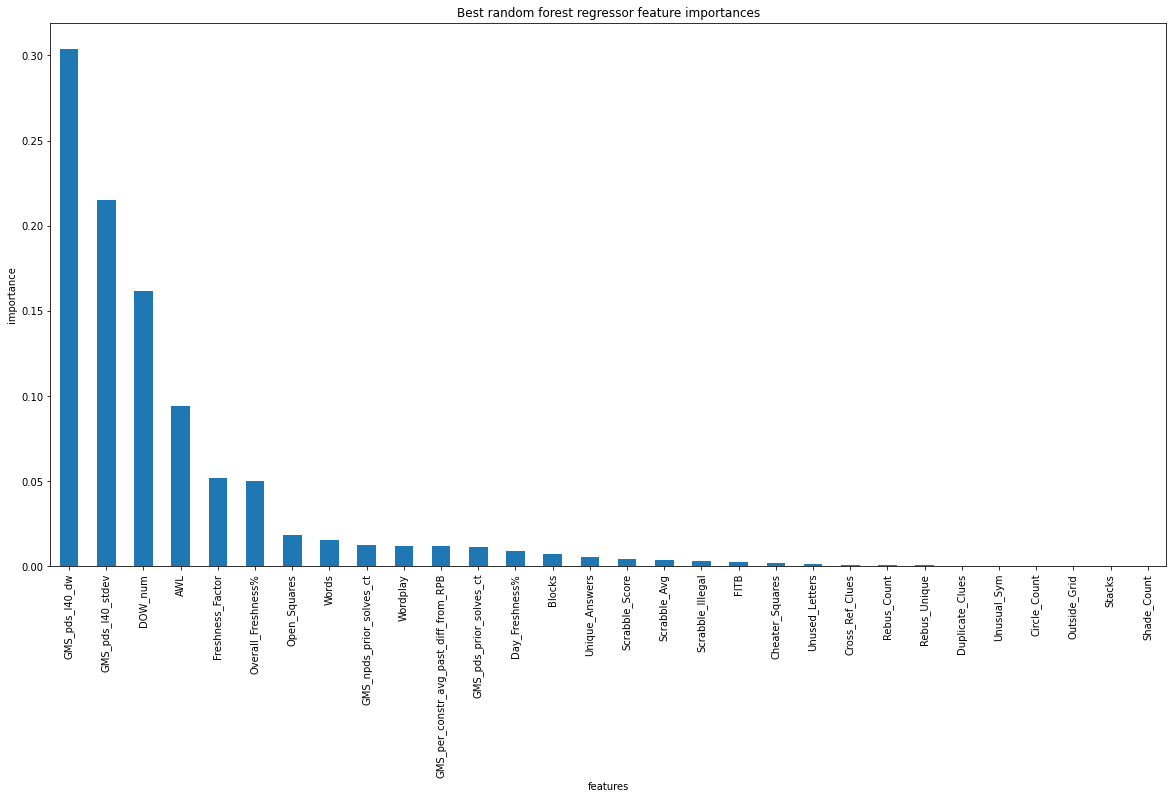

In [80]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.nlargest(30).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

#rf_gridsearch.best_estimator_.named_steps["step_name"].feature_importances_
#rf_gridsearch.best_estimator_.feature_importances_

#feat_importances = pd.Series(rf_grid_cv.feature_importances_, index=rf_grid_cv.columns)
#feat_importances.nlargest(50).plot(kind='barh')

Random Forest Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)

(3.927503234417672, 0.20651632993952265), 3.917560554768995
{'randomforestregressor__n_estimators': [275, 300, 325],
 'randomforestregressor__max_features': [9],
 'randomforestregressor__max_depth': [9, 10, 11],
 'randomforestregressor__min_samples_split': [2],
 'randomforestregressor__min_samples_leaf': [10],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median']}

Note on speed of RF: it could take around 1000 seconds to fit an RF with around 4M samples with the dimensions 'n_estimators': 50, 'max_depth': 200, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_jobs': 20 but only 50s for 'n_estimators': 50, 'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_jobs': 20 for similar accuracy."

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [229]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [230]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [231]:
#Define Grid Parameters

n_est = [130] 
learning_rate = [.06] 
max_depth = [2] 
max_features = [10]
subsamples = [0.6]

grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features,
        'gradientboostingregressor__subsample': subsamples
}
grid_params

#Generally speaking, the four hyperparameters with the biggest impact on this model's performance are the number of models in the ensemble (n_est),
#the learning rate, the depth of the decision tree (max_depth), and the variance of the model controlled via the size of the data sample used to train 
#each model or features used in tree splits

{'gradientboostingregressor__n_estimators': [130],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'gradientboostingregressor__learning_rate': [0.06],
 'gradientboostingregressor__max_depth': [2],
 'gradientboostingregressor__max_features': [10],
 'gradientboostingregressor__subsample': [0.6]}

In [232]:
#First Pass (best from the run is placed outside bracket per hyperparameter)
# {'gradientboostingregressor__n_estimators': [100, 110, 120, 130, 140], 130
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['median', 'mean'], median
#  'gradientboostingregressor__learning_rate': [0.03, 0.04, 0.05, 0.06], .06
#  'gradientboostingregressor__max_depth': [2, 3, 4, 5], 2
#  'gradientboostingregressor__max_features': [9, 10, 11], 10
#  'gradientboostingregressor__subsample': [0.4, 0.6, 0.8, 1]} 0.6

# Second Pass
# {'gradientboostingregressor__n_estimators': [125, 130, 135], 130
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['median'],
#  'gradientboostingregressor__learning_rate': [0.06, 0.07, 0.08], .06
#  'gradientboostingregressor__max_depth': [2],
#  'gradientboostingregressor__max_features': [10],
#  'gradientboostingregressor__subsample': [0.5, 0.6, 0.7]} 0.6

# Third Pass
# {'gradientboostingregressor__n_estimators': [130],
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['median'],
#  'gradientboostingregressor__learning_rate': [0.055, 0.06, 0.065], .06
#  'gradientboostingregressor__max_depth': [2],
#  'gradientboostingregressor__max_features': [10],
#  'gradientboostingregressor__subsample': [0.55, 0.6, 0.65]} .6

In [233]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [234]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.06],
                         'gradientboostingregressor__max_depth': [2],
                         'gradientboostingregressor__max_features': [10],
                         'gradientboostingregressor__n_estimators': [130],
                         'gradientboostingregressor__subsample': [0.6],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [235]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.06,
 'gradientboostingregressor__max_depth': 2,
 'gradientboostingregressor__max_features': 10,
 'gradientboostingregressor__n_estimators': 130,
 'gradientboostingregressor__subsample': 0.6,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}


### Best Gradient Boosting Model Performance Metrics

#### R-squared (COD)

In [236]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

array([0.7395894 , 0.79564371, 0.76191003, 0.77129731, 0.77018579])

In [237]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.7677252490183197, 0.018020528145412548)

#### Mean Absolute Error (MAE)

In [238]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [239]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(2.6954054956543425, 0.06941866914866816)

In [240]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

2.7585444084387873

#### Mean Squared Error (MSE)

In [241]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [242]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

(15.096363249824275, 1.4969879515735052)

In [243]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

15.378511186072252

#### Root Mean Square Error (RMSE)

In [244]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [245]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(3.880761975385794, 0.18986769136434262)

In [246]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

3.921544489875418

### Best Gradient Boosting Model Feature Performance

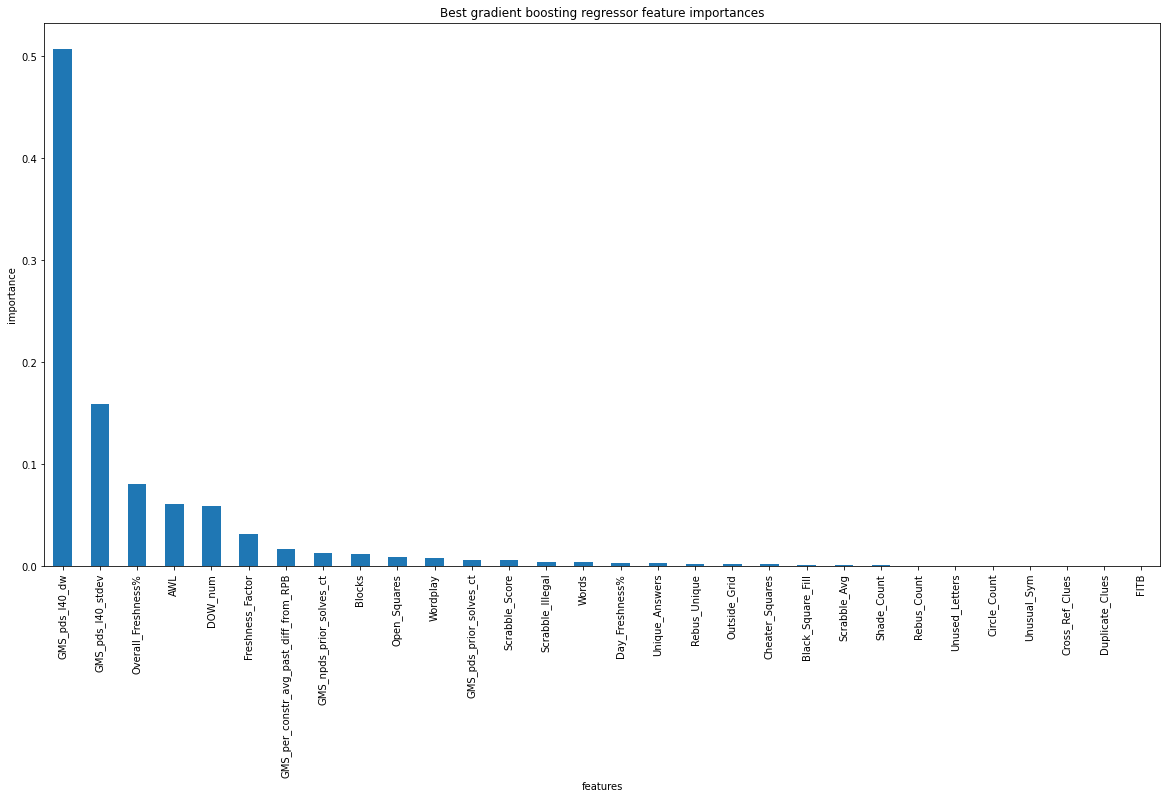

In [247]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
gb_feat_imps.nlargest(30).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

In [248]:
# Export out features and feature importances for full documentation csv
X_train.columns
gb_feat_imps.to_csv('../data/gb_feat_imps.csv', index=True)

### Data Quality Assessment

Because Gradient Boosting Regressor turned out to be the best of the four models tested (in terms of cross-validation RMSE), a Data Quality Assessment was run on this model to ensure that results are not hindered by sample size. Results in that regard are inconclusive, though when this assessment was run on Gradient Boosting Regressor CV score was clearly still rising at the possible edge of the sample max.

In [249]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(GB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

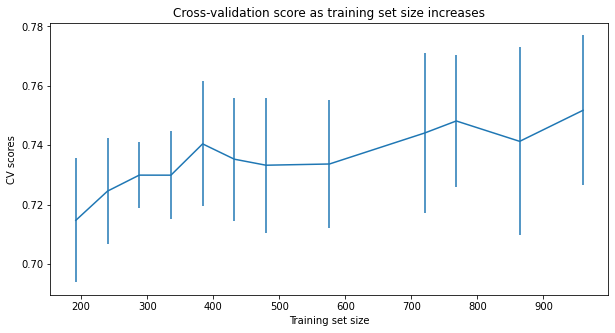

In [250]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

Best GBM Model RMSE Train/Test and Best Hyperparameters



## HistGradientBoosting Model

### Pipeline Creation

In [272]:
#Define pipeline
HGB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    HistGradientBoostingRegressor(random_state= 47)
)

In [273]:
HGB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'histgradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learning_rate', 'histgradientboostingregressor__loss', 'histgradientboostingregressor__max_bins', 'histgradientboostingregressor__max_depth', 'histgradientboostingregressor__max_iter', 'histgradientboostingregressor__max_leaf_nodes', 'histgradientboostingregressor__min_samples_leaf', 'histgradientboostingregressor__monotonic_cst', 'histgradientboostingregressor__n_iter_no_change', 'histgradientboostingregressor__random_state', 'histgradientboosting

### Hyperparameter  Grid Search and Model Fit Using Best Parameters from Grid Search

In [274]:
#Define grid search parameters

learning_rate = [.08]
max_iterations = [85]
max_depth = [3]
max_leaf_nodes = [4]   #default is 31

grid_params = {
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'histgradientboostingregressor__learning_rate': learning_rate,
        'histgradientboostingregressor__max_iter': max_iterations,
        'histgradientboostingregressor__max_depth': max_depth,
        'histgradientboostingregressor__max_leaf_nodes': max_leaf_nodes
}
grid_params

{'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'histgradientboostingregressor__learning_rate': [0.08],
 'histgradientboostingregressor__max_iter': [80, 85, 90],
 'histgradientboostingregressor__max_depth': [3],
 'histgradientboostingregressor__max_leaf_nodes': [4]}

In [275]:
#First Pass
# {'standardscaler': [None],
#  'simpleimputer__strategy': ['mean', 'median'], median
#  'histgradientboostingregressor__learning_rate': [0.03, 0.04, 0.05, 0.06], .06
#  'histgradientboostingregressor__max_iter': [115, 125, 135, 145, 155], 115
#  'histgradientboostingregressor__max_depth': [2, 3, 4], 3
#  'histgradientboostingregressor__max_leaf_nodes': [4, 8, 12, 16, 20]} 4

#Second Pass
# {'standardscaler': [None],
#  'simpleimputer__strategy': ['median'],
#  'histgradientboostingregressor__learning_rate': [0.06, 0.07, 0.08], .08
#  'histgradientboostingregressor__max_iter': [95, 105, 115], 95
#  'histgradientboostingregressor__max_depth': [3],
#  'histgradientboostingregressor__max_leaf_nodes': [2, 4, 6]} 4

#Third Pass
# {'standardscaler': [None],
#  'simpleimputer__strategy': ['median'],
#  'histgradientboostingregressor__learning_rate': [0.08, 0.09, 0.1], .08
#  'histgradientboostingregressor__max_iter': [75, 85, 95], 85 (85 beat 80 and 90 on 4th pass)
#  'histgradientboostingregressor__max_depth': [3],
#  'histgradientboostingregressor__max_leaf_nodes': [4]}

In [276]:
#Call `GridSearchCV` with the hist gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation.
hgb_grid_cv = GridSearchCV(HGB_pipe, param_grid=grid_params, cv=5)

In [277]:
#`GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. 
hgb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor(random_state=47))]),
             param_grid={'histgradientboostingregressor__learning_rate': [0.08],
                         'histgradientboostingregressor__max_depth': [3],
                         'histgradientboostingregressor__max_iter': [80, 85,
                                                                     90],
                         'histgradientboostingregressor__max_leaf_nodes': [4],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [278]:
#Best params (`best_params_` attribute) from the grid search    
hgb_grid_cv.best_params_

{'histgradientboostingregressor__learning_rate': 0.08,
 'histgradientboostingregressor__max_depth': 3,
 'histgradientboostingregressor__max_iter': 85,
 'histgradientboostingregressor__max_leaf_nodes': 4,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Model Cross-Validation and Fit Metrics

#### R-Squared (Training Cross Validation, then Testing)

In [279]:
#Cross-validation defaults to R^2 metric for scoring regression
hgb_best_cv_results = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, cv=5)
hgb_best_scores = hgb_best_cv_results['test_score']
hgb_best_scores

array([0.72688966, 0.79594238, 0.75707017, 0.76857768, 0.7629436 ])

In [280]:
#Training set CV mean and std
np.mean(hgb_best_scores), np.std(hgb_best_scores)

(0.7622846952648594, 0.022148929257931018)

#### Mean Absolute Error (MAE)

In [281]:
hgb_neg_mae = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [282]:
#Training set CV mean and std
hgb_mae_mean = np.mean(-1 * hgb_neg_mae['test_score'])
hgb_mae_std = np.std(-1 * hgb_neg_mae['test_score'])
hgb_mae_mean, hgb_mae_std

(2.720967599540751, 0.08887442991782296)

In [283]:
# Test set mean
mean_absolute_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

2.7533267910465287

#### Mean Squared Error (MSE)

In [284]:
hgb_neg_mse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv= 5)

In [285]:
#Training set CV mean and std
hgb_mse_mean = np.mean(-1 * hgb_neg_mse['test_score'])
hgb_mse_std = np.std(-1 * hgb_neg_mse['test_score'])
hgb_mse_mean, hgb_mse_std

(15.437007313674433, 1.5927973873137087)

In [286]:
# Test set mean
mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

15.112353456560315

#### Root Mean Squred Error (RMSE)

In [287]:
hgb_neg_rmse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [288]:
#Training set CV mean and std
hgb_rmse_mean = np.mean(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_std = np.std(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_mean, hgb_rmse_std

(3.923843008121485, 0.20115506777252656)

In [289]:
# Test set mean
np.sqrt(mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test)))

3.8874610553110776

Hist Gradient Boosting Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)

(3.923843008121485, 0.20115506777252656), 3.8874610553110776

{'histgradientboostingregressor__learning_rate': 0.08,
 'histgradientboostingregressor__max_depth': 3,
 'histgradientboostingregressor__max_iter': 85,
 'histgradientboostingregressor__max_leaf_nodes': 4,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

## Save Best Model Object From Pipeline (Linear Model)

The Linear Model turned out to be the best of the four models tested (based on cross-validation RMSE). Below, the best model is saved to be run on the full dataset in a final step ().  

In [439]:
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [440]:
# save the model
modelpath = '../models'
save_file(best_model, 'IS1_full_best_model_linear.pkl', modelpath)

Writing file.  "../models\IS1_full_best_model_GB.pkl"


### Data Quality Assessment

Because the Linear Model turned out to be the best of the four models tested (in terms of cross-validation RMSE), a Data Quality Assessment was run on this model to ensure that results are not hindered by sample size. Results in that regard are inconclusive, though when this assessment was run on Gradient Boosting Regressor CV score was clearly still rising at the possible edge of the sample max.

In [312]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(lr_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


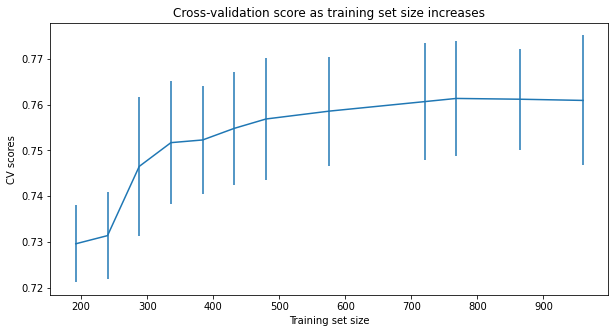

In [313]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');


## Conclusions
